## Background

In this notebook I'll work through the following "Further Research" prompt given at the end of Chapter 13 (Convolutional Neural Networks) of the fastai textbook:

> Other normalization layers are available in PyTorch. Try them out and see what works best. Learn about why other normalization layers have been developed and how they differ from batch normalization.

I'll use the following 5 normalization layers to train separate models and compare model performance and activations:

- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- [InstanceNorm](https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm2d.html)
- [GroupNorm](https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html)
- [Local Response Normalization](https://pytorch.org/docs/stable/generated/torch.nn.LocalResponseNorm.html)
- [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

## Visualizing Activation Normalization Layer Outputs

Before I get into the trainings, I'll visualize the outputs of each normalization layer, given an input batch of MNIST images.

In [1]:
from fastai.vision.all import *
from fastai.callback.hook import *
matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [3]:
# create a function to change dls params
def get_dls(bs=64):
  return DataBlock(
      blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
      get_items=get_image_files,
      splitter=GrandparentSplitter('training', 'testing'),
      get_y=parent_label,
      batch_tfms=Normalize()
  ).dataloaders(path, bs=bs)

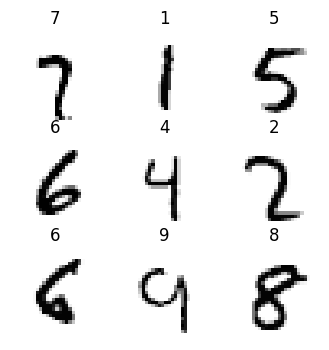

In [4]:
dls = get_dls(512)
dls.show_batch(max_n=9, figsize=(4,4))

In [5]:
xb, yb = dls.one_batch()

### `BatchNorm2d`

First up is `BatchNorm2d` which is the layer we use in Chapter 13 of the fastai textbook when training a CNN.

Here's an image without any normalization applied (left) and the same image after `BatchNorm2d` is applied **to the entire batch** on the right---it looks pretty much the same! :

In [6]:
def plot_ims(a, b):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  im1 = ax1.imshow(a.squeeze());
  ax1.set_title('Original')
  im2 = ax2.imshow(b.detach().numpy().squeeze());
  ax2.set_title('After Normalization Layer Applied')

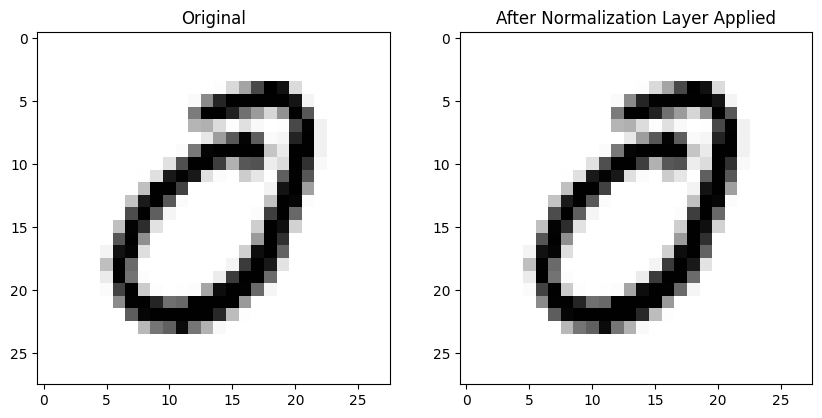

In [7]:
plot_ims(xb[0], nn.BatchNorm2d(1)(xb)[0])

Here is the mean absolute difference between the 784 pixels in both images (pre- and post-normalization)---in other words, not that different!

In [8]:
def mad(a,b): return (a-b).abs().mean()

In [9]:
mad(xb[0], nn.BatchNorm2d(1)(xb)[0])

TensorImageBW(0.0040, grad_fn=<AliasBackward0>)

It wasn't until I asked Claude for an explanation that I understood that this normalization occurs across the entire batch (I know---it's right there in the name!):

Prompt:

> will the normalization be visible per image?

Response (emphasis mine):

> The normalization in BatchNorm2d is not typically visible per individual image. Here's why:
>  
> 1. Channel-wise operation: BatchNorm2d normalizes across the entire batch for each channel.
> 2. Batch statistics: It uses mean and variance computed **over all images in the batch, not per image**.
> 3. Shared parameters: The learnable scale (gamma) and shift (beta) parameters are applied equally to all images.
>4. Subtle effects: The normalization often results in subtle changes that may not be visually apparent.
>5. Purpose: It's designed to stabilize internal representations, **not to visibly alter individual images**.
>6. Inference behavior: During inference, it uses running statistics, further reducing per-image variation.
>  
> To see BatchNorm2d's effect, you'd typically need to analyze the statistical properties of the activations across the entire batch or network, rather than looking at individual images.

Here's a couple other ways to realize this behavior---the mean pixel value per image in the batch is relatively unchanged after `BatchNorm2d` is applied:

In [10]:
def plot_hists(a, b, label_a, label_b, xlabel):
  plt.figure(figsize=(10, 6))
  plt.hist(a, alpha=0.7, color='blue', label=label_a);
  plt.hist(b, alpha=0.7, color='red', label=label_b);
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel('Frequency')
  plt.show()

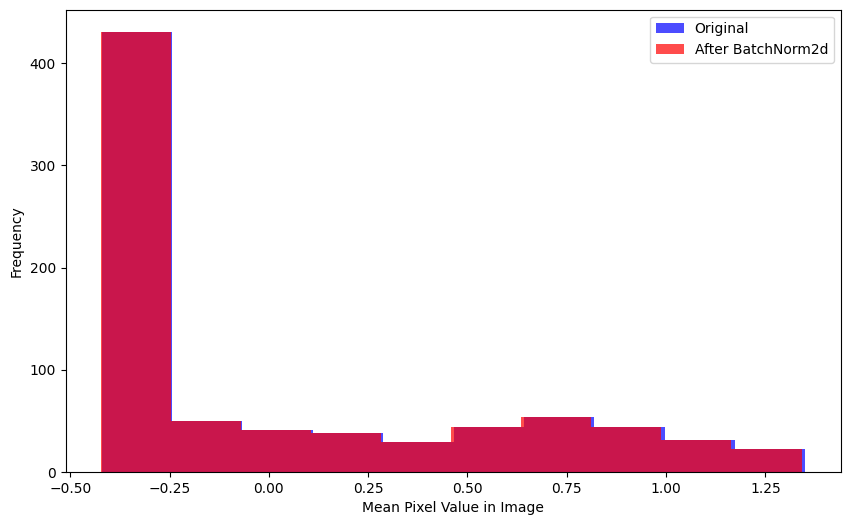

In [11]:
plot_hists(
    a=xb.mean(0).flatten(),
    b=nn.BatchNorm2d(1)(xb).mean(0).flatten().detach().numpy(),
    label_a='Original',
    label_b='After BatchNorm2d',
    xlabel='Mean Pixel Value in Image')

Here is the distribution of pixel values across the entire batch---again, relatively unchanged after `BatchNorm2d` is applied:

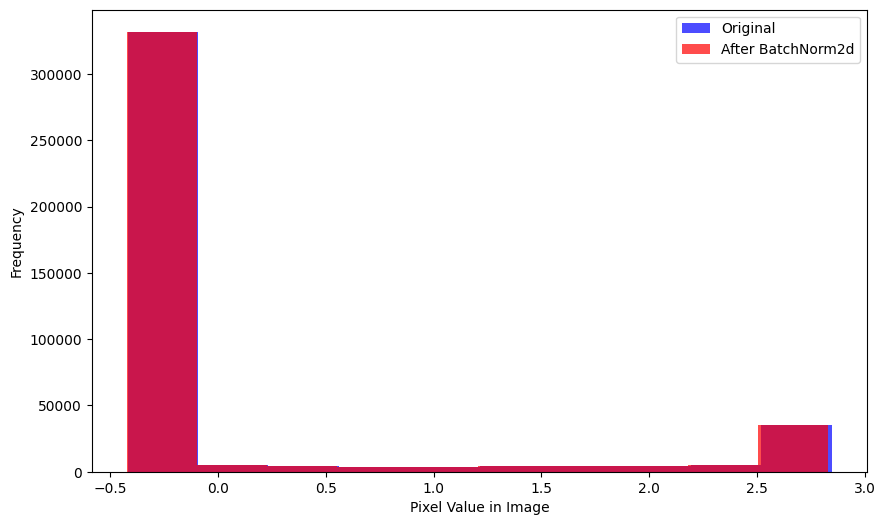

In [12]:
plot_hists(
    a=xb.flatten(),
    b=nn.BatchNorm2d(1)(xb).flatten().detach().numpy(),
    label_a='Original',
    label_b='After BatchNorm2d',
    xlabel='Pixel Value in Image')

After `BatchNorm2d` is applied, the average pixel value in a single image is relatively unchanged **but the average pixel value across a batch is effectively 0**.

In [13]:
def get_means(a, b):
  return a.mean(), b.mean()

In [14]:
get_means(xb[0], nn.BatchNorm2d(1)(xb)[0]) # mean of single image

(TensorImageBW(0.0668), TensorImageBW(0.0628, grad_fn=<AliasBackward0>))

In [15]:
get_means(xb, nn.BatchNorm2d(1)(xb)) # mean of entire batch

(TensorImageBW(0.0037), TensorImageBW(2.1858e-08, grad_fn=<AliasBackward0>))

Interesting to note that in this case, since the standard deviation of the batch is close to 1, it doesn't change much after `BatchNorm2d` is applied:

In [16]:
def get_stds(a, b):
  return a.std(), b.std()

In [17]:
get_stds(xb, nn.BatchNorm2d(1)(xb)) # std of entire batch

(TensorImageBW(1.0045), TensorImageBW(1.0000, grad_fn=<AliasBackward0>))

Lastly, I'll look at the means and standard deviations of 100 batches after `BatchNorm2d` is applied:

In [18]:
def plot_means_stds(norm):
  means = []
  stds = []

  for _ in range(100):
    xb, _ = dls.one_batch()
    means.append(norm(xb).mean().item())
    stds.append(norm(xb).std().item())

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

  ax1.hist(means);
  ax1.set_title('Means')
  ax1.set_xlabel('Value')
  ax1.set_ylabel('Frequency')

  # Plot second histogram
  ax2.hist(stds);
  ax2.set_title('Standard Deviations')
  ax2.set_xlabel('Value')
  ax2.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

As expected, the mean of the batch is effectively 0 and standard deviation is 1 (note that the x-axis for means is 1e-8 and for standard deviations is 1e-7 + 9.99996e-1):

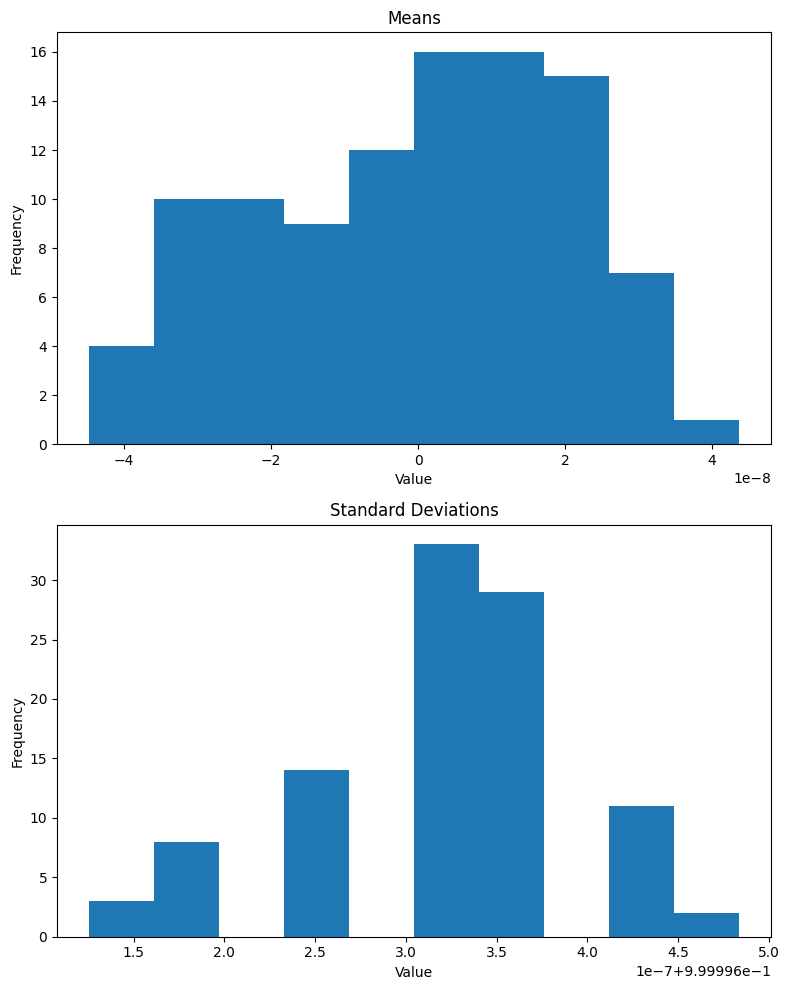

In [19]:
plot_means_stds(nn.BatchNorm2d(1))

### `InstanceNorm2d`

Reading the PyTorch documentation, it seems like `InstanceNorm2d` is similar to `BatchNorm2d` (the formulas look the same). They note that `InstanceNorm2d` is similar to `LayerNorm` which I'll look at later on.

I'll start by instantiating the normalization layer:

In [20]:
inorm = nn.InstanceNorm2d(1)

The individual images effectively look the same before and after `InstanceNorm2d` is applied:

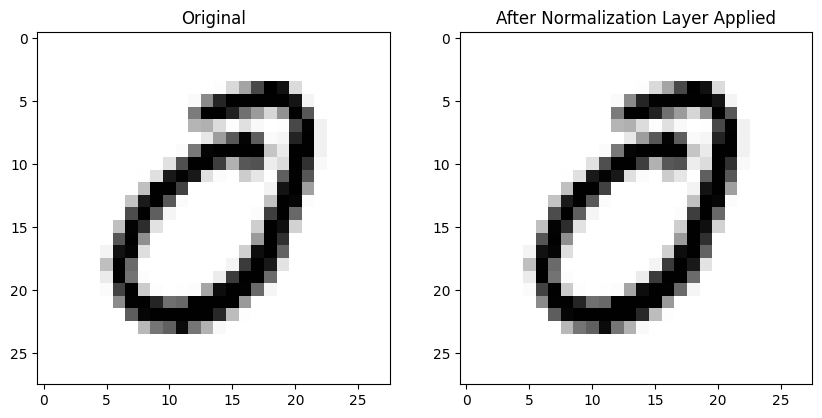

In [21]:
plot_ims(xb[0], inorm(xb)[0])

The mean absolute difference between all 784 pixel values in each image is considerably larger than the difference using `BatchNorm2d`:

In [22]:
mad(xb[0], inorm(xb)[0])

TensorImageBW(0.0668)

The differences between the distributions of mean pixel value in each image before/after `InstanceNorm2d` is applied seems larger than the difference in distributions before/after `BatchNorm2d` is applied.

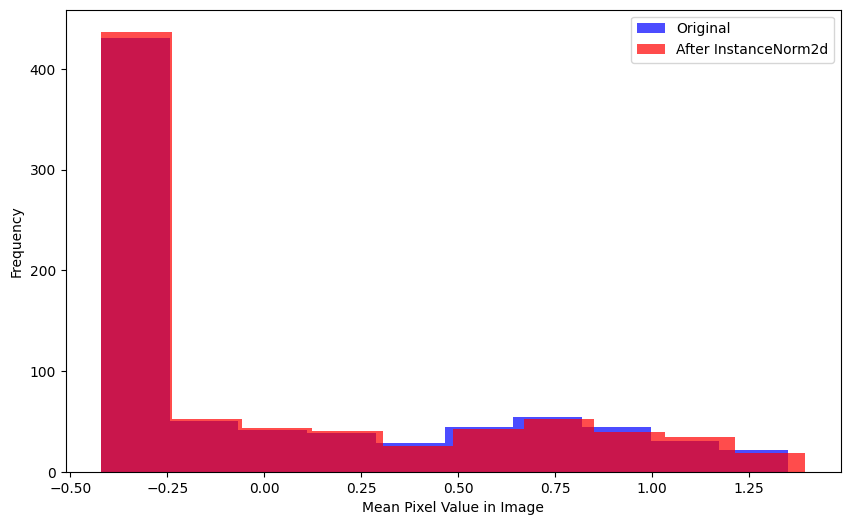

In [23]:
plot_hists(
    a=xb.mean(0).flatten(),
    b=inorm(xb).mean(0).flatten().detach().numpy(),
    label_a='Original',
    label_b='After InstanceNorm2d',
    xlabel='Mean Pixel Value in Image')

A considerable number of pixels in the batch, after `InstanceNorm2d` is applied, have more negative values than the original batch.

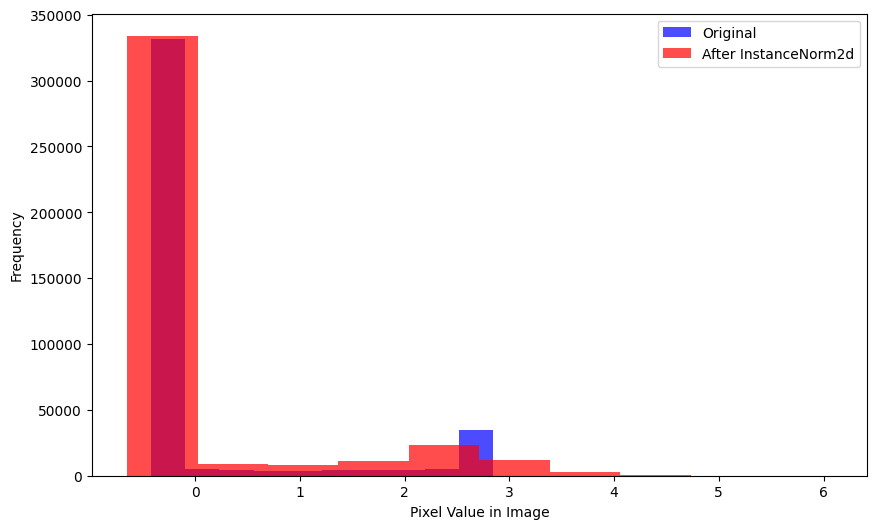

In [24]:
plot_hists(
    a=xb.flatten(),
    b=inorm(xb).flatten().detach().numpy(),
    label_a='Original',
    label_b='After InstanceNorm2d',
    xlabel='Pixel Value in Image')

The mean of a single image is lower after `InstanceNorm2d` is applied:

In [25]:
get_means(xb[0], inorm(xb)[0]) # mean of single image

(TensorImageBW(0.0668), TensorImageBW(7.9067e-09))

The mean of the batch is lower as well:

In [26]:
get_means(xb, inorm(xb)) # mean of entire batch

(TensorImageBW(0.0037), TensorImageBW(-8.3629e-10))

The standard deviation of a batch is 1:

In [27]:
get_stds(xb, inorm(xb)) # std of entire batch

(TensorImageBW(1.0045), TensorImageBW(1.0000))

Similar to `BatchNorm2d`, the mean and standard deviation for a batch is about 0 and 1, respectively, for `InstanceNorm2d`.

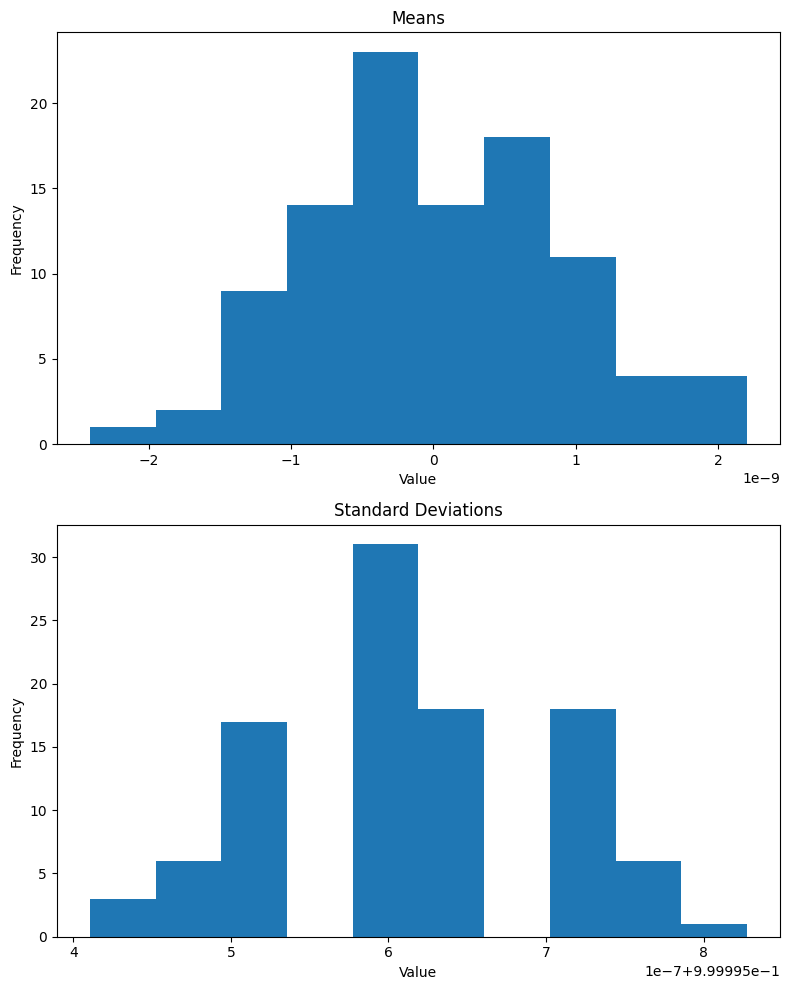

In [28]:
plot_means_stds(inorm)

### `GroupNorm`

This normalization layer normalizes the data across the specified `num_groups`, so it's like `BatchNorm2d` but for groups in the batch.

The documentation states that:

> `num_channels` must be divisible by `num_groups`

So in the case of my MNIST black-and-white single-channel images, I would expect `GroupNorm` results to be the same as `BatchNorm2d`.

In [29]:
gnorm = nn.GroupNorm(1, 1)

The individual image remains unchanged (at least by inspection):

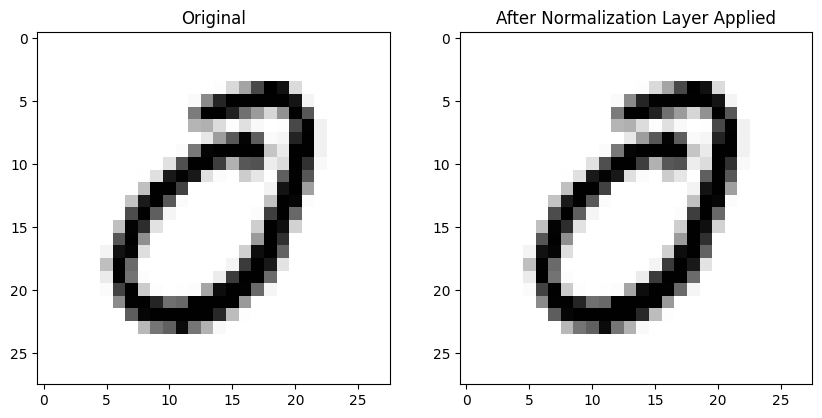

In [30]:
plot_ims(xb[0], gnorm(xb)[0])

The mean average difference between pre- and post-`GroupNorm` image is larger than `BatchNorm2d`:

In [31]:
mad(xb[0], gnorm(xb)[0])

TensorImageBW(0.0668, grad_fn=<AliasBackward0>)

There's visually more variance between the mean image distribution before/after `GroupNorm` than `BatchNorm2d`:

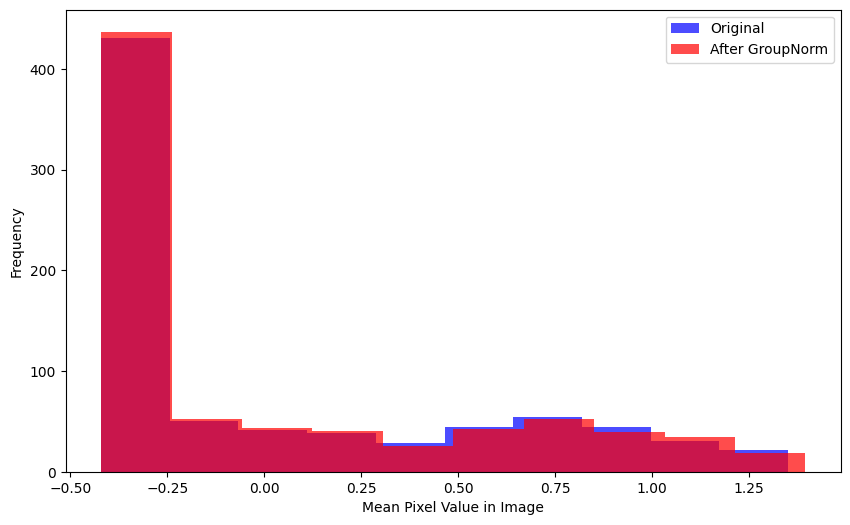

In [32]:
plot_hists(
    a=xb.mean(0).flatten(),
    b=gnorm(xb).mean(0).flatten().detach().numpy(),
    label_a='Original',
    label_b='After GroupNorm',
    xlabel='Mean Pixel Value in Image')

There is a considerable difference between pre- and post-`GroupNorm` distributions (by visual inspection):

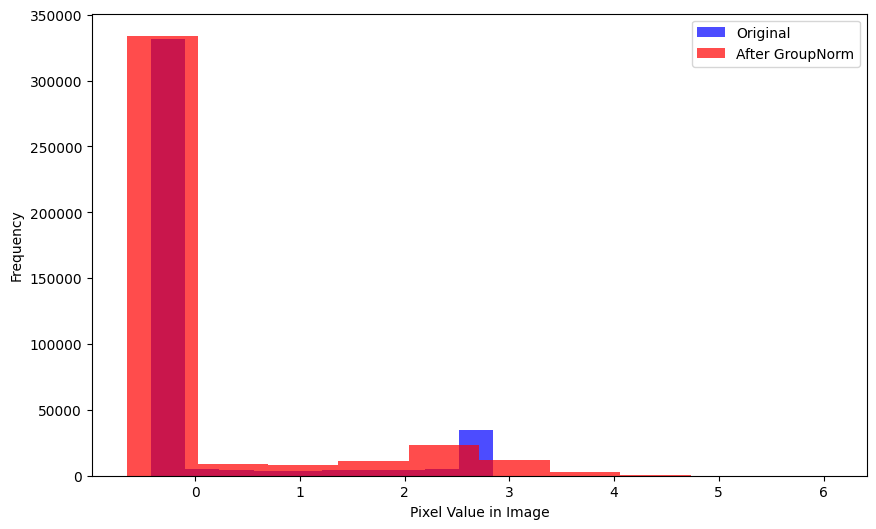

In [33]:
plot_hists(
    a=xb.flatten(),
    b=gnorm(xb).flatten().detach().numpy(),
    label_a='Original',
    label_b='After GroupNorm',
    xlabel='Pixel Value in Image')

The mean pixel value for the given image is effectively 0 after `GroupNorm` is applied:

In [35]:
get_means(xb[0], gnorm(xb)[0]) # mean of single image

(TensorImageBW(0.0668), TensorImageBW(2.3112e-08, grad_fn=<AliasBackward0>))

As is the mean of a given batch:

In [36]:
get_means(xb, gnorm(xb)) # mean of entire batch

(TensorImageBW(0.0037), TensorImageBW(1.9007e-10, grad_fn=<AliasBackward0>))

The standard deviation of the single batch is 1:

In [37]:
get_stds(xb, gnorm(xb)) # std of entire batch

(TensorImageBW(1.0045), TensorImageBW(1.0000, grad_fn=<AliasBackward0>))

While the mean and standard deviation of the 100 batches is close to 0 and 1 respectively, the distributions of mean for `GroupNorm` is centered around 1e-9 while `BatchNorm2d` and `InstanceNorm` were centered around 0.

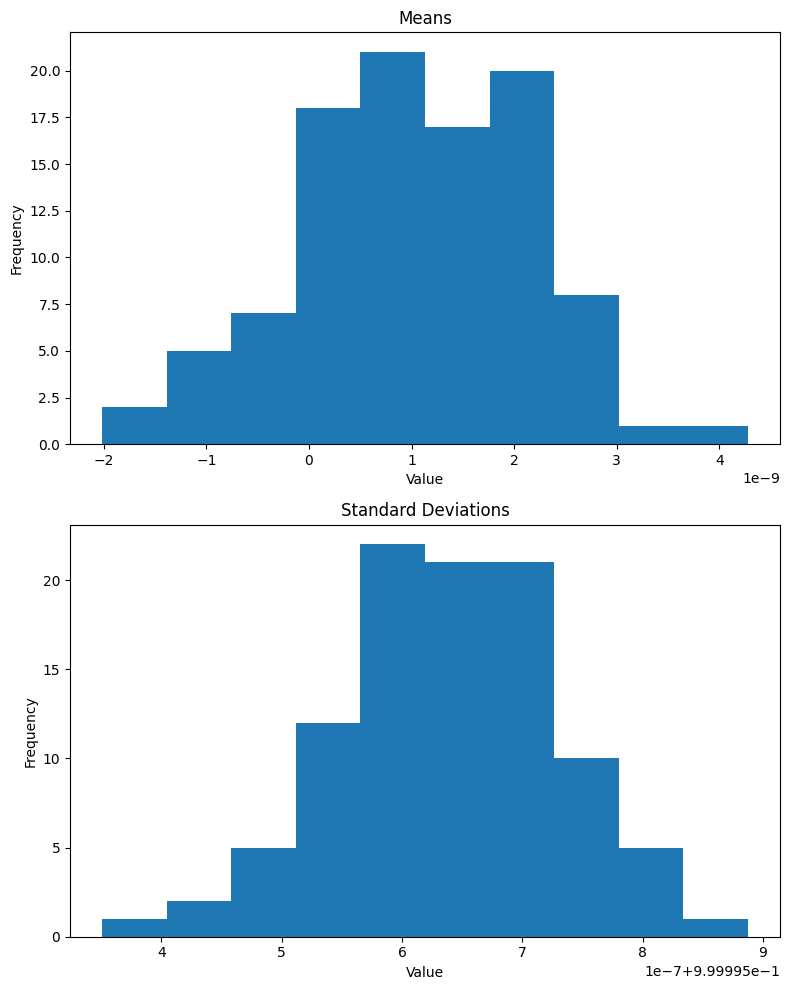

In [38]:
plot_means_stds(gnorm)

### `LocalResponseNorm`

The PyTorch docs describe this normalization layer as follows:

> Applies local response normalization over an input signal.
>  
> The input signal is composed of several input planes, where channels occupy the second dimension. Applies normalization across channels.

Given that I only have one channel (BW images) I expect the normalization effect to be similar to `BatchNorm2d`. I'll use the default settings first:

In [39]:
lrnorm = nn.LocalResponseNorm(1)

No noticeable difference in an individual image after applying `LocalResponseNorm`:

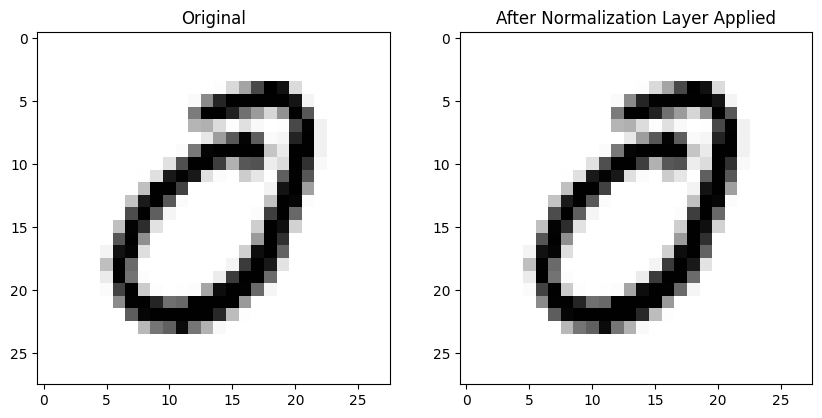

In [40]:
plot_ims(xb[0], lrnorm(xb)[0])

The mean absolute difference is the lowest so far across all normalization layers:

In [41]:
mad(xb[0], lrnorm(xb)[0])

TensorImageBW(0.0002)

The distributions of mean pixels are virtually indistinguishable:

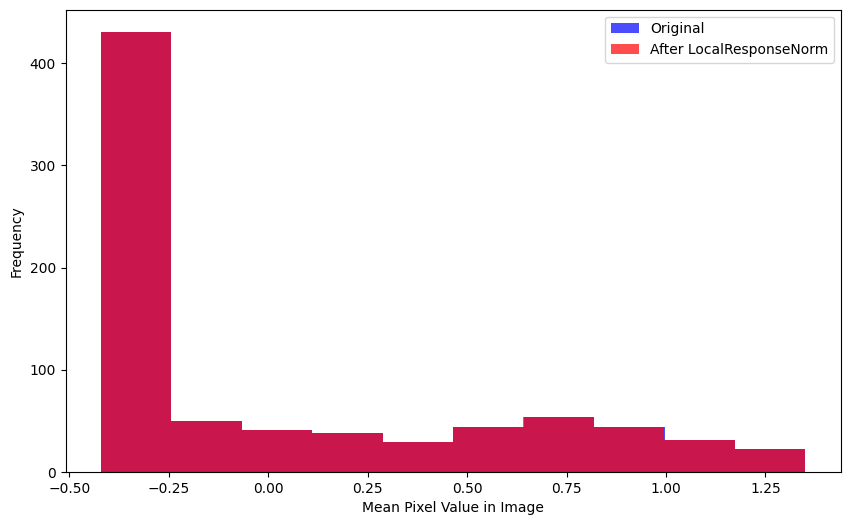

In [42]:
plot_hists(
    a=xb.mean(0).flatten(),
    b=lrnorm(xb).mean(0).flatten().detach().numpy(),
    label_a='Original',
    label_b='After LocalResponseNorm',
    xlabel='Mean Pixel Value in Image')

As are the distributions of pixel values:

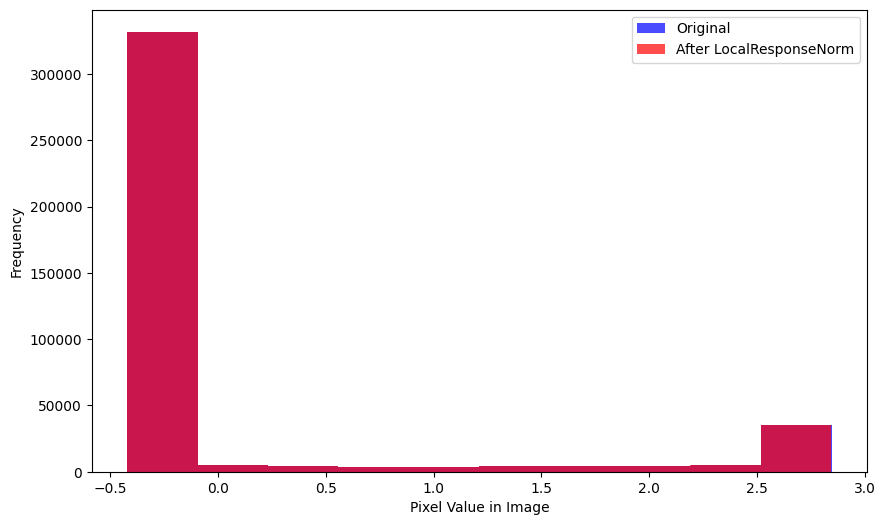

In [43]:
plot_hists(
    a=xb.flatten(),
    b=lrnorm(xb).flatten().detach().numpy(),
    label_a='Original',
    label_b='After LocalResponseNorm',
    xlabel='Pixel Value in Image')

Following suit, the mean of a single image doesn't change much:

In [44]:
get_means(xb[0], lrnorm(xb)[0]) # mean of single image

(TensorImageBW(0.0668), TensorImageBW(0.0666))

Neither does the mean of a batch:

In [46]:
get_means(xb, lrnorm(xb)) # mean of entire batch

(TensorImageBW(0.0037), TensorImageBW(0.0035))

Nor does the standard deviation of a batch:

In [47]:
get_stds(xb, lrnorm(xb)) # std of entire batch

(TensorImageBW(1.0045), TensorImageBW(1.0041))

The mean value of the 100 batches (with `LocalResponseNorm` applied) varies significantly---from -0.005 to +0.015. The standard deviation is more tightly distributed around 1.0. Overall, the default values of `LocalResponseNorm` don't show signs of significantly changing the distribution of values for the images across the batch.

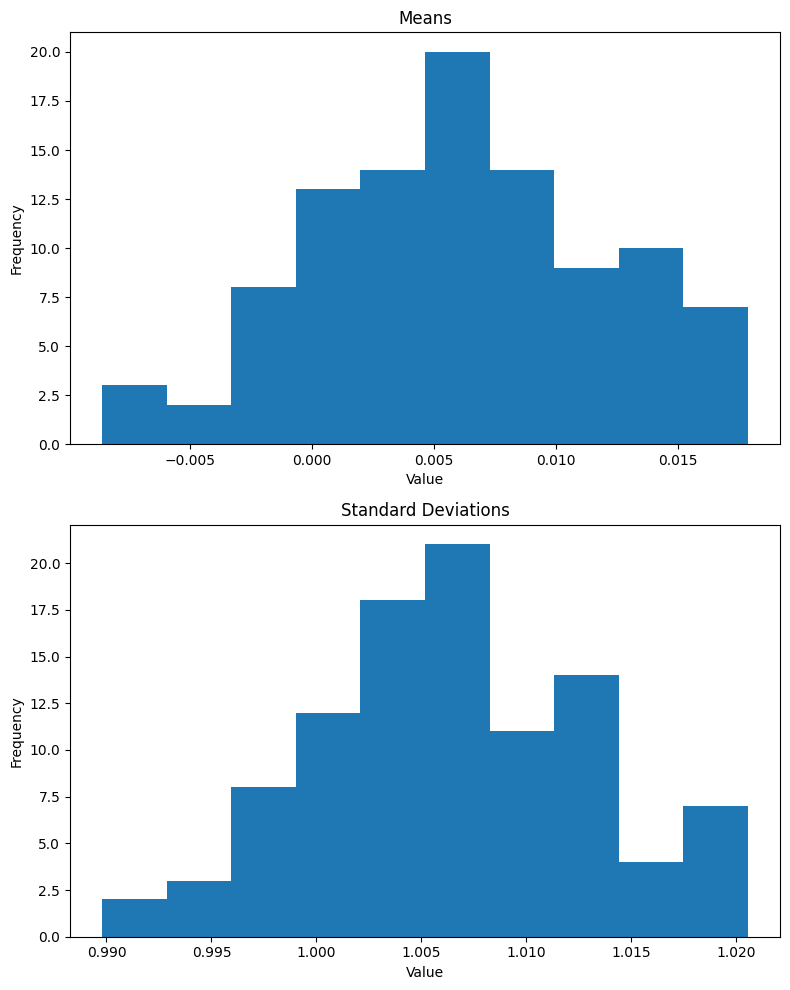

In [48]:
plot_means_stds(lrnorm)

What if I change some the default values? I'll vary the values of the following parameters until I see a significant difference either in individual images or across batches: `alpha`, `beta` and `k`.

Changing the `alpha` parameter significantly changes the individual image as well as the mean and standard deviation across the batch:

In [49]:
lrnorm = nn.LocalResponseNorm(size=1, alpha=1)

In [51]:
get_means(xb, lrnorm(xb)), \
get_stds(xb, lrnorm(xb))

((TensorImageBW(0.0037), TensorImageBW(-0.2167)),
 (TensorImageBW(1.0045), TensorImageBW(0.3405)))

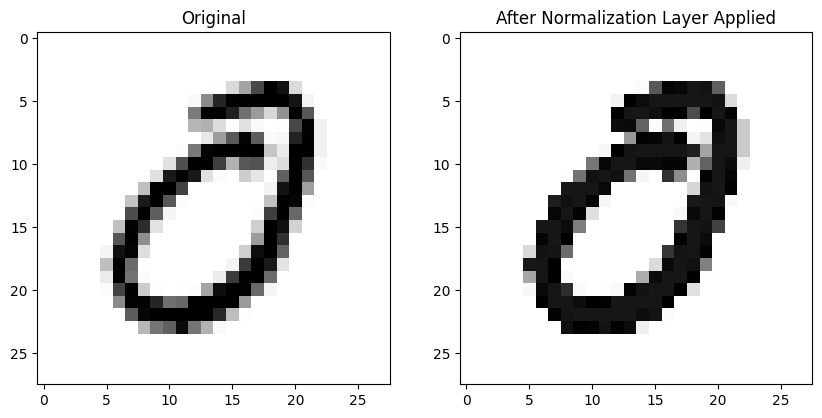

In [52]:
plot_ims(xb[0], lrnorm(xb)[0])

Changing the `beta` parameter doesn't affect the images as much:

In [53]:
lrnorm = nn.LocalResponseNorm(size=1, beta=10)

In [54]:
get_means(xb, lrnorm(xb)), \
get_stds(xb, lrnorm(xb))

((TensorImageBW(0.0037), TensorImageBW(0.0015)),
 (TensorImageBW(1.0045), TensorImageBW(0.9985)))

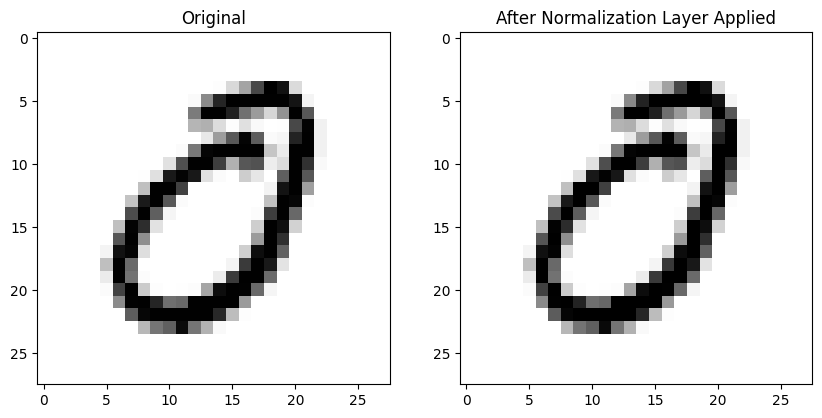

In [55]:
plot_ims(xb[0], lrnorm(xb)[0])

Changing the `k` parameter doesn't change individual images much but it does affect the batch statistics:

In [56]:
lrnorm = nn.LocalResponseNorm(size=1, k=10)

In [57]:
get_means(xb, lrnorm(xb)), \
get_stds(xb, lrnorm(xb))

((TensorImageBW(0.0037), TensorImageBW(0.0007)),
 (TensorImageBW(1.0045), TensorImageBW(0.1786)))

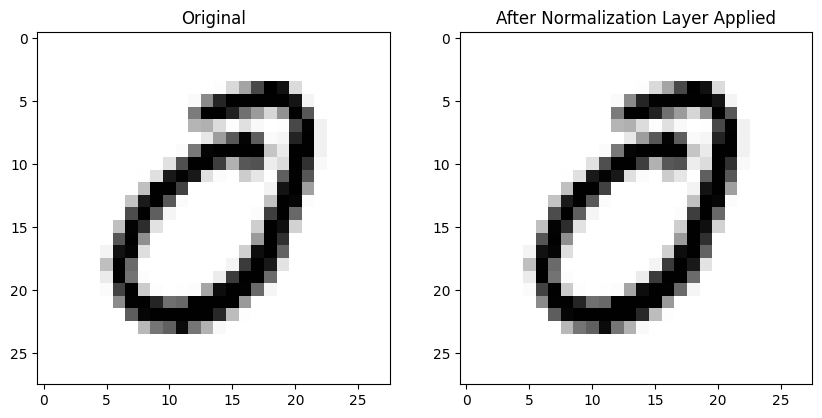

In [58]:
plot_ims(xb[0], lrnorm(xb)[0])

### `LayerNorm`

`LayerNorm` is different from the other normalization layers in the sense that you can explicitly determine which dimensions the normalization occurs across.

I'll try different sets of dimensions and plot the images and calculate image and batch statistics.

Setting the `normalized_shape` parameter to the last dimension (`[28]`) affects the individual image as well as the batch mean:

In [60]:
lnorm = nn.LayerNorm(normalized_shape=[28]) # last dimension

In [61]:
get_means(xb, lnorm(xb)), \
get_stds(xb, lnorm(xb))

((TensorImageBW(0.0037), TensorImageBW(5.7020e-10, grad_fn=<AliasBackward0>)),
 (TensorImageBW(1.0045), TensorImageBW(0.8411, grad_fn=<AliasBackward0>)))

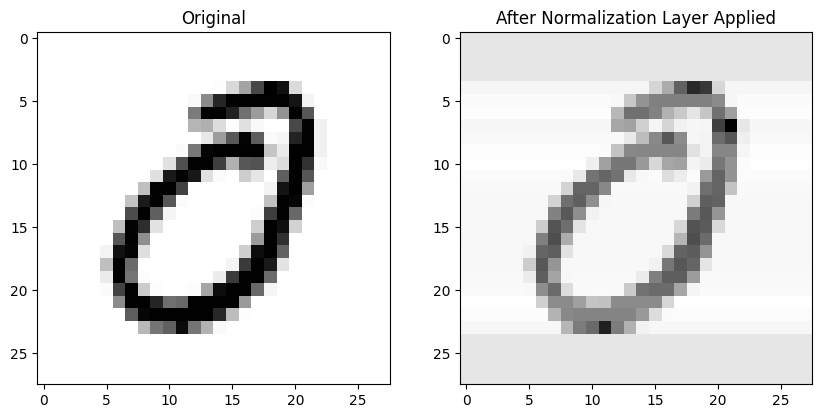

In [62]:
plot_ims(xb[0], lnorm(xb)[0])

Setting `normalized_shape` to the last two dimensions (`[28, 28]`) significantly affects the batch mean (it goes to `0`) and sets the batch standard deviation to `1`. The individual image does not seem affected:

In [63]:
lnorm = nn.LayerNorm(normalized_shape=[28, 28]) # last two dimensions

In [64]:
get_means(xb, lnorm(xb)), \
get_stds(xb, lnorm(xb))

((TensorImageBW(0.0037), TensorImageBW(9.5033e-10, grad_fn=<AliasBackward0>)),
 (TensorImageBW(1.0045), TensorImageBW(1.0000, grad_fn=<AliasBackward0>)))

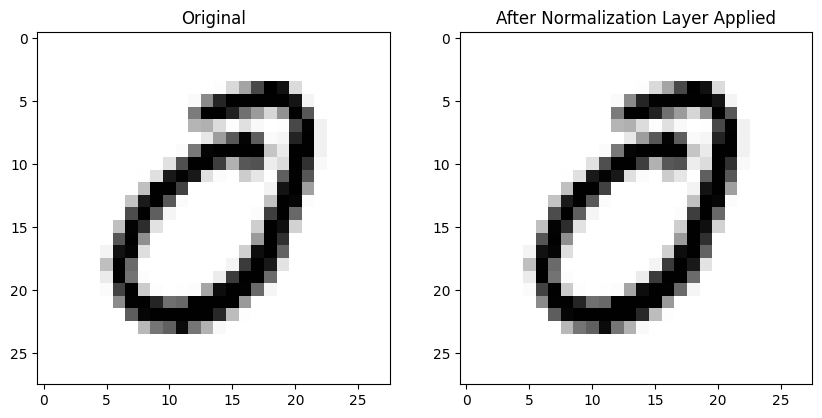

In [65]:
plot_ims(xb[0], lnorm(xb)[0])

Setting `normalized_shape` to the last three dimensions has a similar effect:

In [69]:
lnorm = nn.LayerNorm(normalized_shape=[1, 28, 28]) # last three dimensions

In [70]:
get_means(xb, lnorm(xb)), \
get_stds(xb, lnorm(xb))

((TensorImageBW(0.0037), TensorImageBW(9.5033e-10, grad_fn=<AliasBackward0>)),
 (TensorImageBW(1.0045), TensorImageBW(1.0000, grad_fn=<AliasBackward0>)))

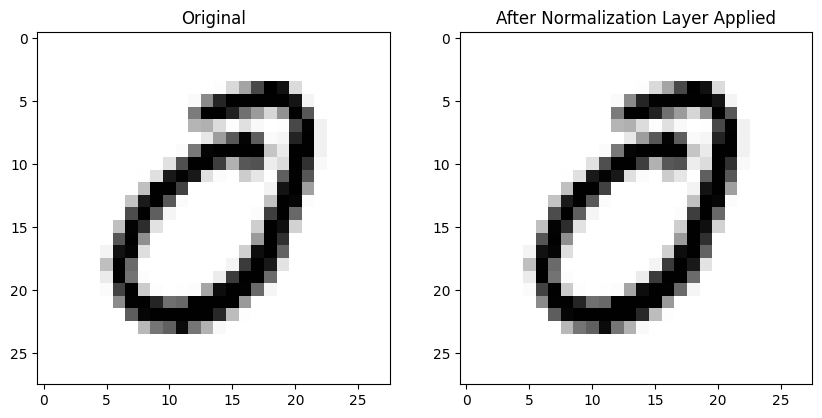

In [71]:
plot_ims(xb[0], lnorm(xb)[0])

I'll run through my helper functions for this scenario as it seems most similar to `BatchNorm2d`, `InstanceNorm2d` and `GroupNorm`.

The mean absolute difference between the image before/after normalization is similar to `BatchNorm2d`:

In [72]:
mad(xb[0], lnorm(xb)[0])

TensorImageBW(0.0668, grad_fn=<AliasBackward0>)

There is some visually distinguishable difference between the mean pixel value in each image before/after `LayerNorm` is applied:

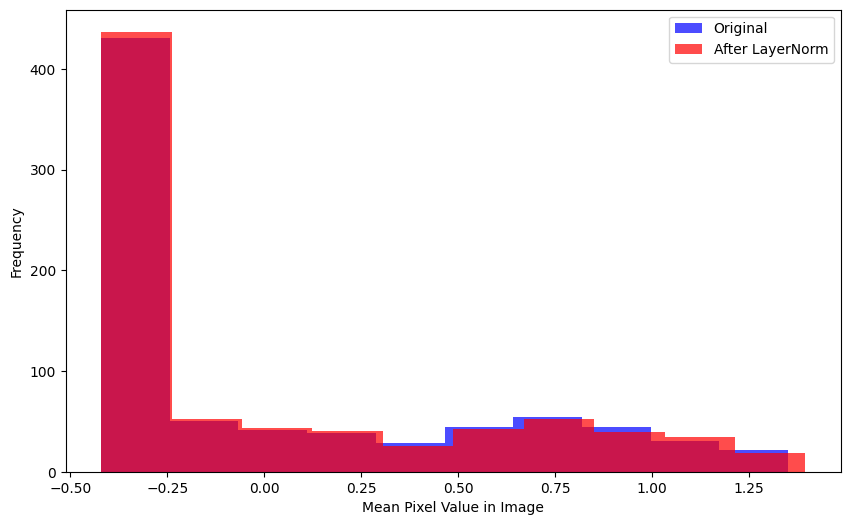

In [73]:
plot_hists(
    a=xb.mean(0).flatten(),
    b=lnorm(xb).mean(0).flatten().detach().numpy(),
    label_a='Original',
    label_b='After LayerNorm',
    xlabel='Mean Pixel Value in Image')

Same goes for the distributions of pixel values:

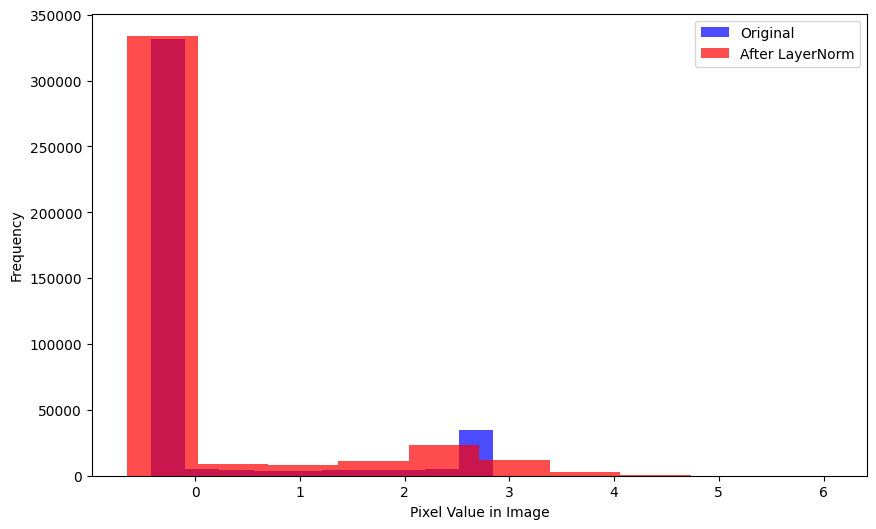

In [74]:
plot_hists(
    a=xb.flatten(),
    b=lnorm(xb).flatten().detach().numpy(),
    label_a='Original',
    label_b='After LayerNorm',
    xlabel='Pixel Value in Image')

Across the 100 batches, the means are centered around 1e-9 (like `GroupNorm`) and the standard deviations are similarly distributed around 1.

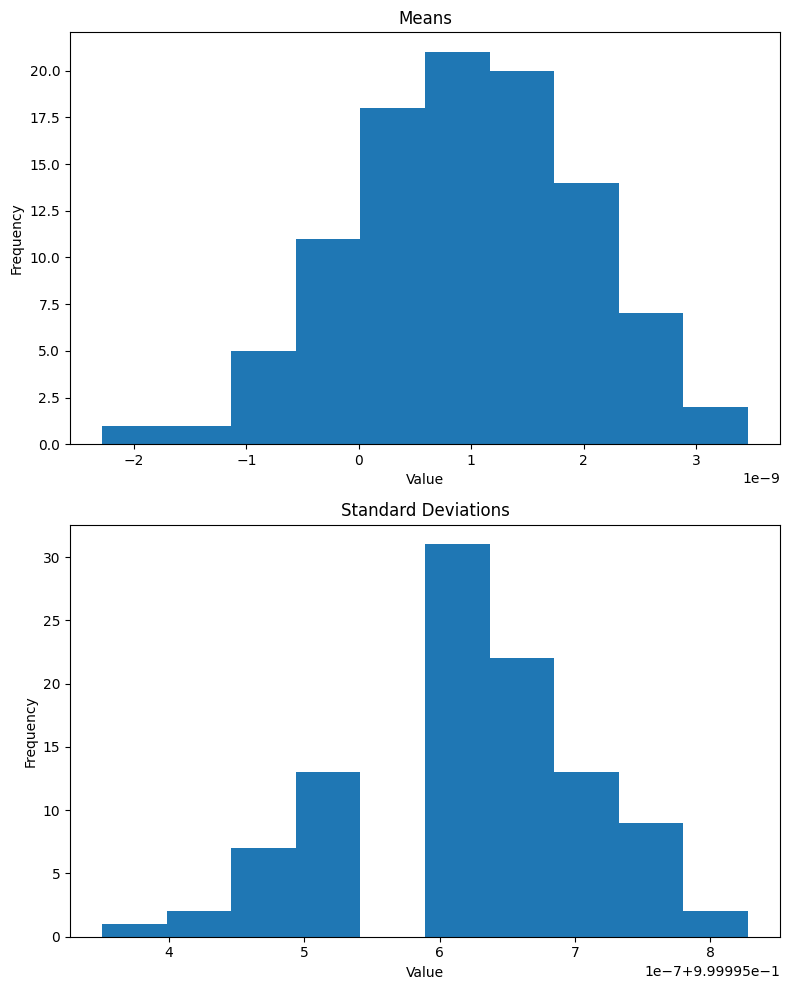

In [75]:
plot_means_stds(lnorm)

## Training Models Using Different Normalization Layers

Now that I'm a bit more familiar with the behavior of the activation normalization layers on the MNIST dataset, I'll train models using them and compare between them their final validation accuracy as well as their `activation_stats`.

I'm modifying `simple_cnn` so that the `conv` function receives `output_shape` since `nn.LayerNorm` uses that as the `normalized_shape` parameter. The `output_shape` is based on 28x28 input images to the model.

In [9]:
def simple_cnn():
  return sequential(
      conv(1, 8, output_shape=[14,14], ks=5),         # 14x14
      conv(8, 16, output_shape=[7,7]),              # 7x7
      conv(16, 32, output_shape=[4,4]),             # 4x4
      conv(32, 64, output_shape=[2,2]),             # 2x2
      conv(64, 10, output_shape=[1,1], act=False),  # 1x1
      Flatten()
  )

In [10]:
def fit(epochs=5, lr=0.1):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  with learn.no_logging(), learn.no_bar(): learn.fit_one_cycle(epochs, lr)
  return learn

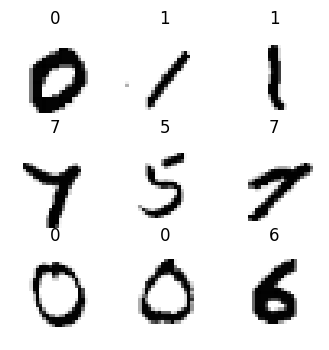

In [6]:
dls = get_dls(512)
dls.show_batch(max_n=9, figsize=(4,4))

I'll define a list of all the activation normalization layers I'll use and a `data` object that will store the training results. Note that I am not using `nn.InstanceNorm2d` since I get the following error when attempting to train with it:

```
ValueError: Expected more than 1 spatial element when training, got input size torch.Size([512, 10, 1, 1])
```

[This PyTorch forum's post](https://discuss.pytorch.org/t/instance-norm-valueerror-expected-more-than-1-spatial-element-when-training-got-input-size-torch-size-128-512-1-1/159620/2) explains that for `InstanceNorm2d`, in the input $(N,C,H,W)$, $H$ and $W$ must be greater than 1. In my model the output of the final convolution will be 1x1 (for each of the 10 numbers). I don't want to change the architecture for `InstanceNorm2d` since I won't be able to compare apples-to-apples with the other normalization layers, so I'm deciding not to use it.

For `nn.GroupNorm`, I'm using `num_groups` of `2` since that was giving me the highest accuracy when compared to lower or higher values (after quickly training for 1 epoch). I'm using a `size` of `2` for `nn.LocalResponseNorm` since it gave higher validation accuracy than lower or higher values (after training for 1 epoch).

In [11]:
norms = [
    nn.BatchNorm2d,
    nn.GroupNorm,
    nn.LocalResponseNorm,
    nn.LayerNorm
]

In [12]:
data = {
    'BatchNorm2d': None,
    'GroupNorm': None,
    'LocalResponseNorm': None,
    'LayerNorm': None
}

For each normalization layer, I'll train 10 models for 5 epochs each, storing the `activation_stats.layer_stats`, `activation_stats.hist` and `learn.recorder.values[-1][-1]` (final accuracy).

In [13]:
for norm in norms:
  layer_stats = L()
  hists = L()
  accs = L()

  def conv(ni, nf, output_shape, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]

    if norm.__name__ in ['BatchNorm2d', 'InstanceNorm2d']: normlayer = norm(nf)
    if norm.__name__ == 'GroupNorm': normlayer = norm(1, nf)
    if norm.__name__ == 'LocalResponseNorm': normlayer = norm(2)
    if norm.__name__ == 'LayerNorm': normlayer = nn.LayerNorm([nf] + output_shape)

    layers.append(normlayer)
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

  for _ in range(10):
    learn = fit()
    layer_stats.append(learn.activation_stats.layer_stats(-2))
    hists.append(learn.activation_stats.hist(-4))
    accs.append(learn.recorder.values[-1][-1])

  data[norm.__name__] = {'layer_stats': layer_stats, 'hists': hists, 'accs': accs}
  save_pickle('/content/data.pkl', data)
  print(f'{norm.__name__} ---- done.')

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


BatchNorm2d ---- done.
GroupNorm ---- done.
LocalResponseNorm ---- done.
LayerNorm ---- done.


### Analyzing Training Results

#### Final Validation Accuracy

Time to look at the results! I'll start by comparing the median, mean, std, min and max final validation accuracy between the different activation normalization layers.

Across 10 training runs (for 5 epochs each) `BatchNorm2d` had the highest median (0.9924) and mean (0.99227) final validation accuracy as well as the lowest standard deviation (0.000495). `LocalResponseNorm` had one training run with a final validation accuracy of 0.1135!

In [37]:
accs = pd.DataFrame({key: data[key]['accs'] for key in data})
accs.describe().loc[['mean', '50%', 'std', 'min', 'max']]

,BatchNorm2d,GroupNorm,LocalResponseNorm,LayerNorm
mean,0.992270,0.990560,0.883270,0.990400
50%,0.992400,0.990700,0.971700,0.990500
std,0.000495,0.000799,0.270729,0.000523
min,0.991100,0.989100,0.113500,0.989400
max,0.992800,0.991500,0.979300,0.991000


#### Activation Stats

Next, I'll look at the `activation_stats` across the training runs for each of the four normalization layers.

In [54]:
def plot_stats_avg(layer_stats_list, titles, super_title, labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(super_title, fontsize=16)

    colors = ['red', 'blue', 'green', 'orange']

    for i, title in enumerate(titles):
        for j, layer_stats in enumerate(layer_stats_list):
            y = layer_stats.itemgot(i)
            x = range(len(y[0]))

            y_median = np.median(np.stack(y), axis=0)
            axs[i].plot(x, y_median, color=colors[j], alpha=0.5, linewidth=1, label=labels[j])

        axs[i].set_title(f"Median {title} Activations Across 10 Trainings")
        axs[i].set_xlabel("Batch")
        axs[i].set_ylabel(f"{title}")
        axs[i].legend()

    plt.tight_layout()
    plt.show()

`LocalResponseNorm` (green line) has the most unstable trainings---the average mean activations for it are an order of magnitude more negative than the other three normalization layers; the mean standard deviations are an order of magnitude more positive; it has the highest mean %-near-zero activations, with almost 100% activations near zero on average by the end of the training run.

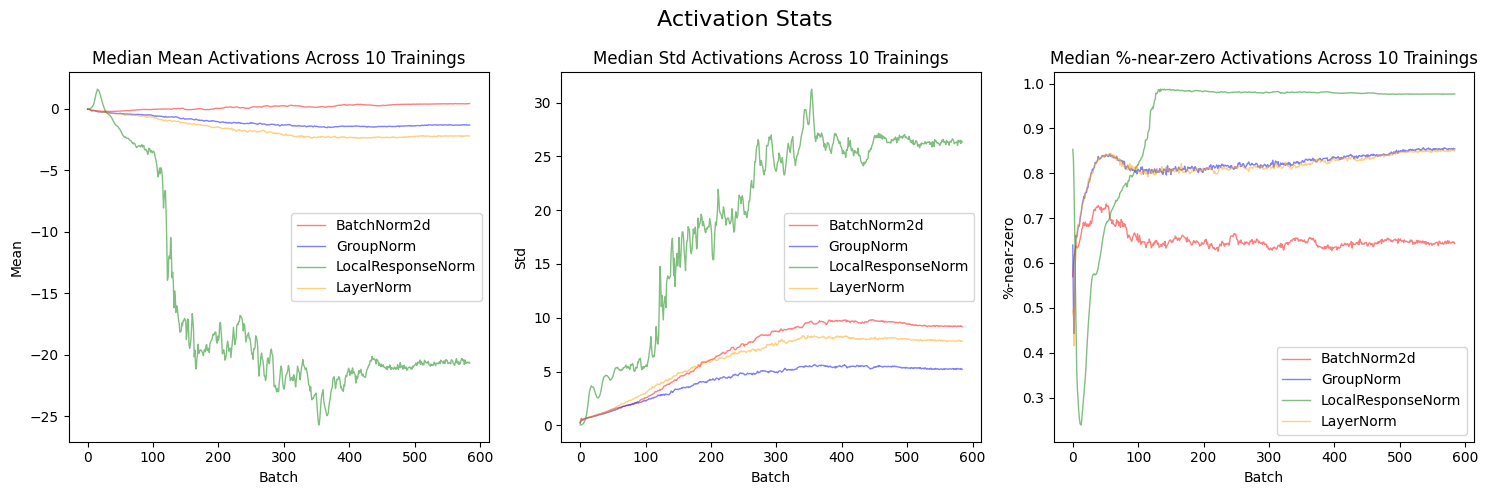

In [55]:
layer_stats_list = [data[key]['layer_stats'] for key in data.keys()]
labels = list(data.keys())
plot_stats_avg(layer_stats_list, ['Mean', 'Std', '%-near-zero'], 'Activation Stats', labels)

After excluding `LocalResponseNorm`, I can see the other three layers' training results more clearly.

The median of mean activations for `BatchNorm2d` (red line) across 10 trainings are the closest to 0 throughout the training when compared to `GroupNorm` (blue line) or `LayerNorm` (green line). `BatchNorm2d` has the highest median standard deviations. `BatchNorm2d` has the lowest %-near-zero activations---plateauing at around 65% by the end of the training. After looking at these charts, I would say that `BatchNorm2d` has the most stable trainings.

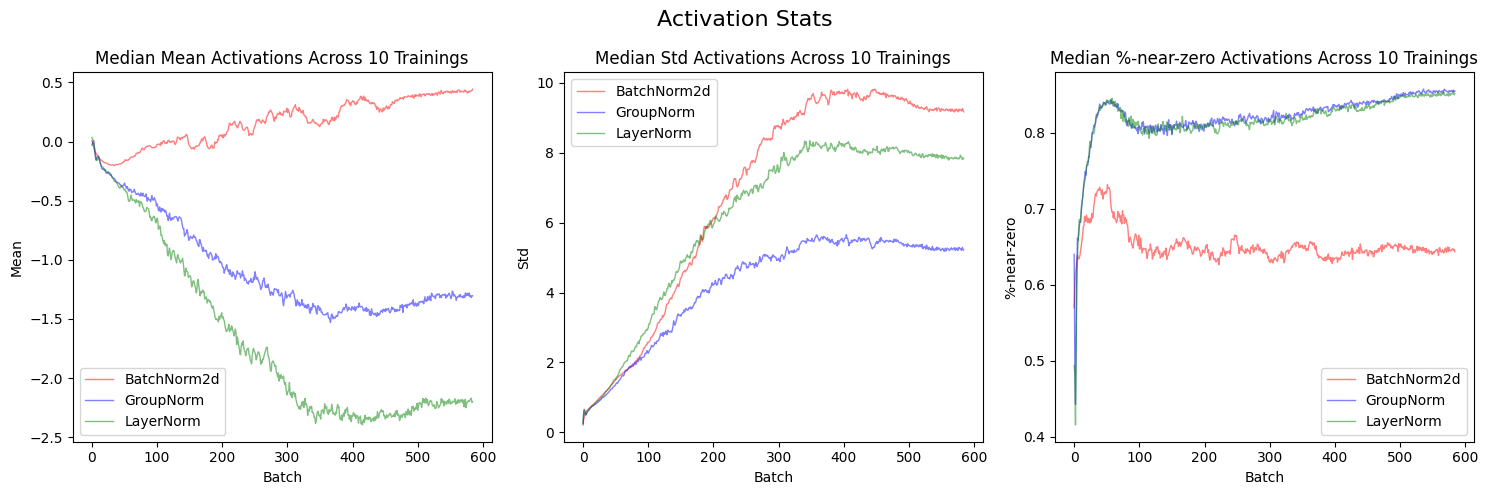

In [56]:
layer_stats_list = [data[key]['layer_stats'] for key in data.keys() if key != 'LocalResponseNorm']
plot_stats_avg(layer_stats_list, ['Mean', 'Std', '%-near-zero'], 'Activation Stats', ['BatchNorm2d', 'GroupNorm', 'LayerNorm'])

#### Activation Histograms

Finally, I'll look at the mean and median value of the histograms of activations across the 10 training runs for each normalization layer:

In [68]:
def plot_hist_avg(hist, super_title):
  fig, axs = plt.subplots(2, 1, figsize=(20, 5))
  fig.suptitle(super_title, fontsize=16)
  h_mean = torch.stack(list(hist)).mean(0)
  h_median = torch.stack(list(hist)).median(0)[0]

  axs[0].imshow(h_mean, origin='lower');
  axs[0].set_title(f"Mean Activations Across 10 Trainings")
  axs[0].axis('off');

  axs[1].imshow(h_median, origin='lower');
  axs[1].set_title(f"Median Activations Across 10 Trainings")
  axs[1].axis('off');

`BatchNorm2d` results in mean and median histogram values that look similar to the fastai textbook example of a stable training. The number of zero-activations decrease smoothly over the first epoch or so.

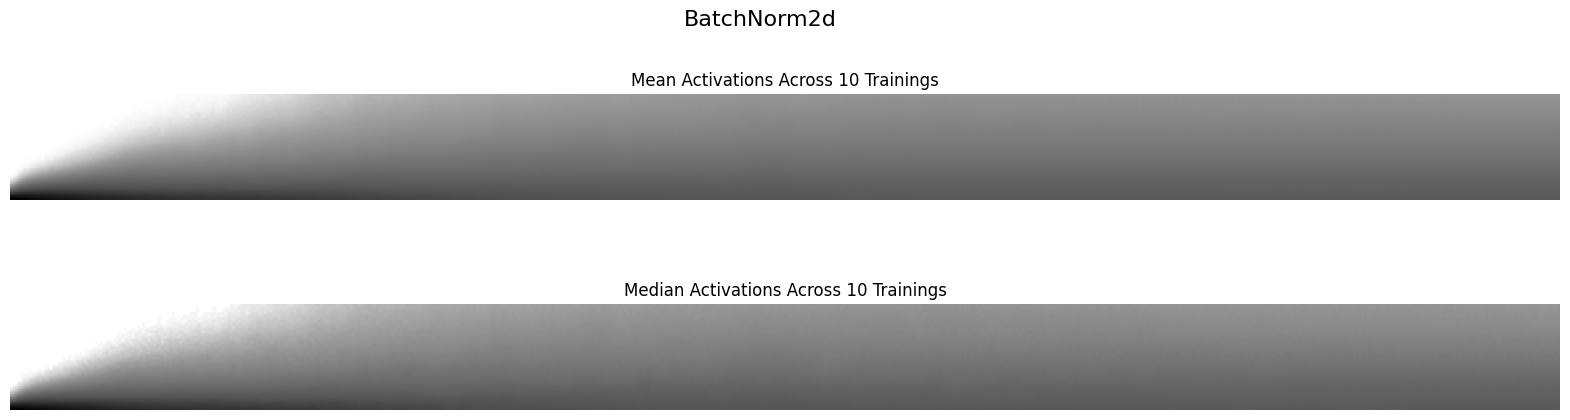

In [69]:
plot_hist_avg(data['BatchNorm2d']['hists'], "BatchNorm2d");

The `GroupNorm` activations are a bit more turbulent, as you can see slight striations of alternating white and grey that indicate small "collapses" of activations in the first epoch before the training stabilizes. I would consider this less stable than `BatchNorm2d`.

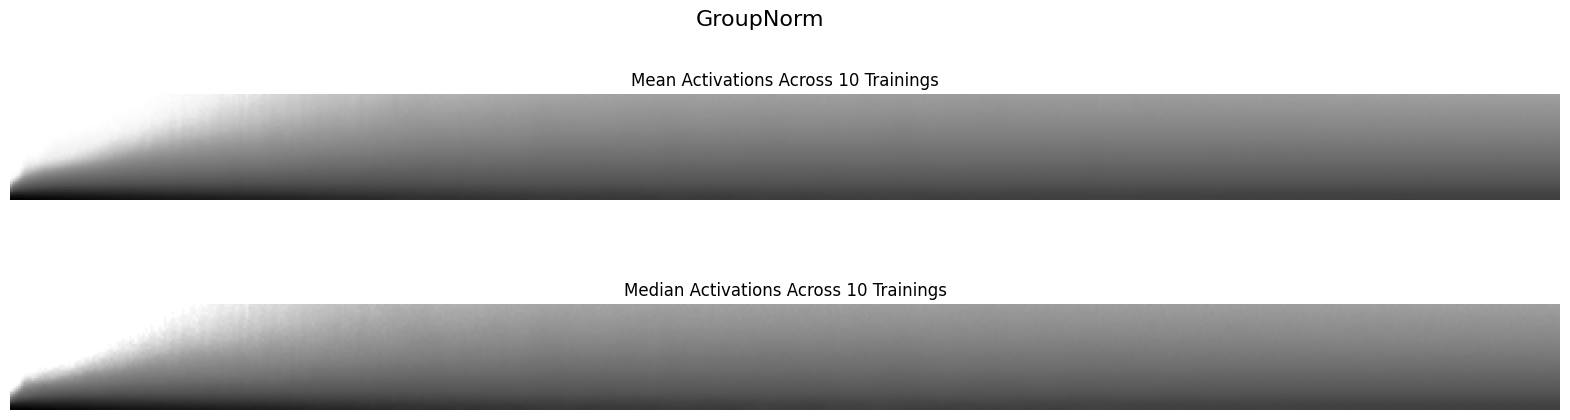

In [72]:
plot_hist_avg(data['GroupNorm']['hists'], "GroupNorm");

`LocalResponseNorm` continues to be the worst normalization layer and the most turbulent as the training shows a clear sign of collapsing activations in the first epoch and continues to show a high number of zero-activations across the training run.

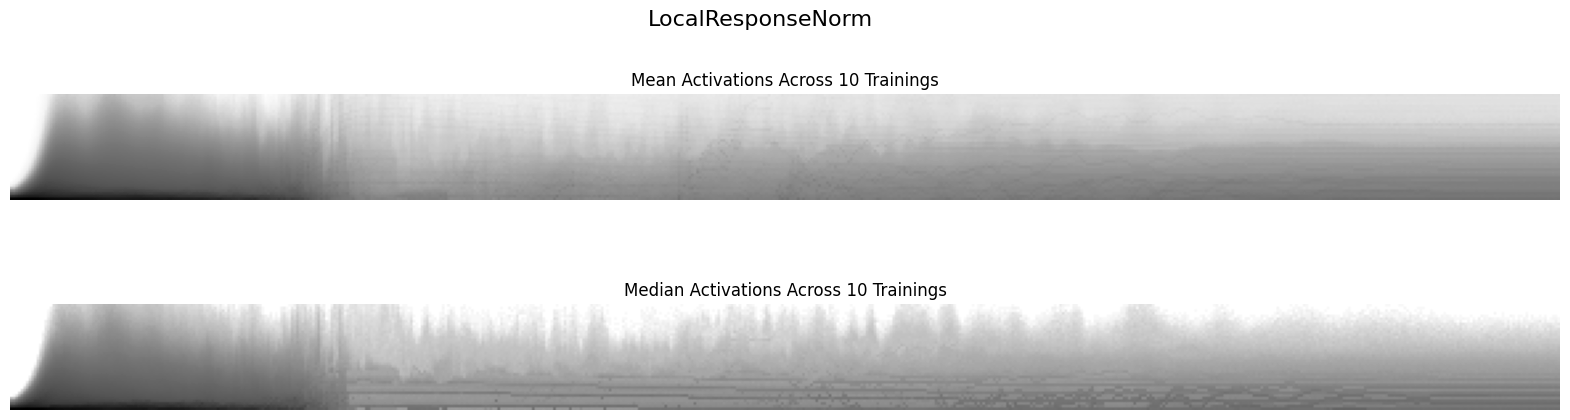

In [73]:
plot_hist_avg(data['LocalResponseNorm']['hists'], "LocalResponseNorm");

Using `LayerNorm` results in a more stable training; it looks similar to the `BatchNorm2d` histograms.

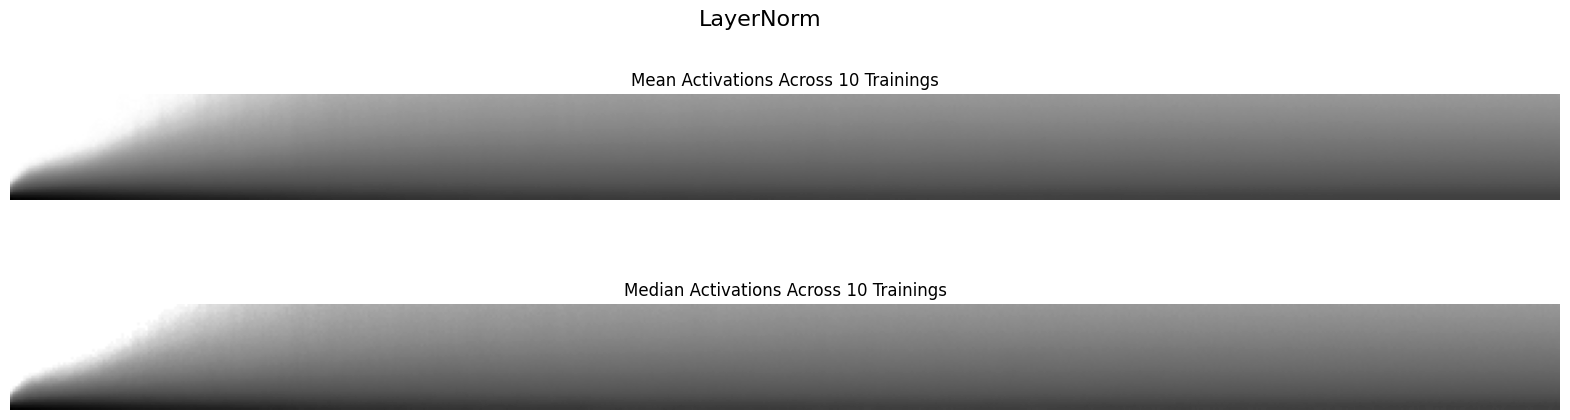

In [74]:
plot_hist_avg(data['LayerNorm']['hists'], "LayerNorm");

## Final Thoughts

This exercise continued to illustrate just how rich the world of deep learning is! I feel like I just scratched the surface of understanding how different activation normalization layers behave, and even that required a considerable amount of time and effort.

Overall from my relatively simple experiments `BatchNorm2d` seems like the best layer to use for this data. Of course there are many hyperparameters that I didn't exhaustively tune (other than quickly training 1-epoch models to see how changing 1 hyperparameter like `num_groups` for `GroupNorm` affected the validation accuracy) and so these results might not be optimal.

However, there's something to be said about being able to just use `BatchNorm2d` without worrying about hyperparameters and getting the best results.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).